# IBM Capstone Project - Analysing Berlin boroughs

## Introduction/Business Problem

House prices in Berlin have gone up dramatically in the last few years. This presents a critical challenge for policy makers and the general population. One of the main culprit is often said to be short lets.

The purpose of this notebook is give an overview of all areas in Berlin, and finding out what factors are most relevant when determining a dramatic change in prices. This will help figuring out which area in Berlin may be most convenient to move in for a young professional and for other cohorts, and which area has the highest potential for return on investment for real estate purchase.

## Data

I will be leveraging the Foursquare API to provide geolocation information about the different boroughs of Berlin.

For this analysys, we'll look at the difference in pricing for short lets in each area, and then correlate that with the venues and facilities available. AirBnb prices tend to affect house prices in a particular area, so this will be one of the data sources I will be using. InsideAirbnb provides a dataset of listings for Berlin, including prices, area, and type of listing.

The amount of venues in an area, especially restaurants and cafes, also tends to be an indicator of a popular area, as well as offices, tech companies. For this, I will be using the Foursquare datasets.

Proximity to public transport, availability of services and facilities and schools are also factors to be taken into account. This data will be retrieved using the Foursquare API.

### Neighborhoods

Let's use data available at InsideAirbnb to create a table of all Berlin neighborhoods. I'll load this from the public URL and do some clean-up to remove empty rows and rename the columns. I'll then group neighbordhoods in the same borough.

In [1]:
import pandas as pd
import numpy as np

pd.set_option('precision', 2)

neighURL = "http://data.insideairbnb.com/germany/be/berlin/2019-07-11/visualisations/neighbourhoods.csv"

berlin_df = pd.read_csv(neighURL, skip_blank_lines=True)
berlin_df.dropna(inplace=True)

berlin_df.columns = ['Borough','Neighborhood']

Let's then merge the neighborhoods from the same borough

In [2]:
berlin_df = berlin_df.groupby(['Borough'])['Neighborhood'].apply(lambda x: ','.join(x.astype(str))).reset_index()
berlin_df

,Borough,Neighborhood
0,Charlottenburg-Wilm.,"Barstraße,Charlottenburg Nord,Düsseldorfer Str..."
1,Friedrichshain-Kreuzberg,"Frankfurter Allee Nord,Frankfurter Allee Süd F..."
2,Lichtenberg,"Alt-Hohenschönhausen Nord,Alt-Hohenschönhausen..."
3,Marzahn - Hellersdorf,"Biesdorf,Hellersdorf-Nord,Hellersdorf-Ost,Hell..."
4,Mitte,"Alexanderplatz,Brunnenstr. Nord,Brunnenstr. Sü..."
5,Neukölln,"Britz,Buckow,Buckow Nord,Gropiusstadt,Köllnisc..."
6,Pankow,"Blankenburg/Heinersdorf/Märchenland,Blankenfel..."
7,Reinickendorf,"MV 1,MV 2,Nord 1,Nord 2,Ost 1,Ost 2,West 1,Wes..."
8,Spandau,"Brunsbütteler Damm,Falkenhagener Feld,Gatow / ..."
9,Steglitz - Zehlendorf,"Albrechtstr.,Drakestr.,Lankwitz,Ostpreußendamm..."


### Airbnb Listings

In the same way, we retrieve the listings data from InsideAirbnb and manipulate the data to make it more useful. In this case, I'll drop some columns as we don't need those pieces of information, and rename some columns for consistency.

In [3]:
listingsURL = "http://data.insideairbnb.com/germany/be/berlin/2019-07-11/visualisations/listings.csv"
listings_df = pd.read_csv(listingsURL, skip_blank_lines=True)

In [4]:
listings_df.drop(columns=['name','id','host_name', 'host_id', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'], inplace=True)
listings_df.rename(columns={"neighbourhood_group": "Borough", "neighbourhood": "Neighborhood"}, inplace=True)
listings_df.head()

,Borough,Neighborhood,latitude,longitude,room_type,price
0,Mitte,Brunnenstr. Nord,52.54,13.40,Private room,21
1,Mitte,Brunnenstr. Süd,52.53,13.40,Entire home/apt,60
2,Pankow,Prenzlauer Berg Südwest,52.53,13.42,Entire home/apt,90
3,Tempelhof - Schöneberg,Schöneberg-Nord,52.50,13.35,Private room,28
4,Friedrichshain-Kreuzberg,Frankfurter Allee Süd FK,52.51,13.45,Entire home/apt,125


Let's visualise Airbnb prices in Berlin:

In [5]:
listings_df['price'].describe()

count    24395.00
mean        70.85
std        214.40
min          0.00
25%         32.00
50%         50.00
75%         75.00
max       9000.00
Name: price, dtype: float64

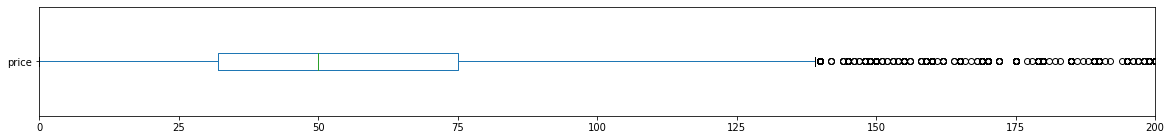

In [7]:
import matplotlib.pyplot as plt

plot = listings_df['price'].plot(kind='box', xlim=(0, 200), vert=False, figsize=(20,2));

Let's now work on this data to get meaningful information. Let's add how many listings there are for each borough.

In [8]:
listings_count = listings_df['Borough'].value_counts(dropna=False)
listings_count = pd.DataFrame(listings_count.reset_index())
listings_count.columns = ['Borough', 'Listings']
listings_count

,Borough,Listings
0,Friedrichshain-Kreuzberg,5854
1,Mitte,5082
2,Pankow,3818
3,Neukölln,3753
4,Charlottenburg-Wilm.,1766
5,Tempelhof - Schöneberg,1610
6,Lichtenberg,792
7,Treptow - Köpenick,647
8,Steglitz - Zehlendorf,489
9,Reinickendorf,304


In [9]:
berlin_df = pd.merge(berlin_df, listings_count, on='Borough')
berlin_df

,Borough,Neighborhood,Listings
0,Charlottenburg-Wilm.,"Barstraße,Charlottenburg Nord,Düsseldorfer Str...",1766
1,Friedrichshain-Kreuzberg,"Frankfurter Allee Nord,Frankfurter Allee Süd F...",5854
2,Lichtenberg,"Alt-Hohenschönhausen Nord,Alt-Hohenschönhausen...",792
3,Marzahn - Hellersdorf,"Biesdorf,Hellersdorf-Nord,Hellersdorf-Ost,Hell...",142
4,Mitte,"Alexanderplatz,Brunnenstr. Nord,Brunnenstr. Sü...",5082
5,Neukölln,"Britz,Buckow,Buckow Nord,Gropiusstadt,Köllnisc...",3753
6,Pankow,"Blankenburg/Heinersdorf/Märchenland,Blankenfel...",3818
7,Reinickendorf,"MV 1,MV 2,Nord 1,Nord 2,Ost 1,Ost 2,West 1,Wes...",304
8,Spandau,"Brunsbütteler Damm,Falkenhagener Feld,Gatow / ...",138
9,Steglitz - Zehlendorf,"Albrechtstr.,Drakestr.,Lankwitz,Ostpreußendamm...",489


And the average price per borough.

In [10]:
mean_prices = listings_df.groupby('Borough')['price'].mean()
mean_prices = pd.DataFrame(mean_prices.reset_index())
mean_prices.columns = ['Borough', 'AveragePrice']
mean_prices

,Borough,AveragePrice
0,Charlottenburg-Wilm.,109.46
1,Friedrichshain-Kreuzberg,65.17
2,Lichtenberg,66.10
3,Marzahn - Hellersdorf,61.42
4,Mitte,75.46
5,Neukölln,49.19
6,Pankow,72.89
7,Reinickendorf,46.61
8,Spandau,59.83
9,Steglitz - Zehlendorf,60.36


In [11]:
berlin_df = pd.merge(berlin_df, mean_prices, on='Borough')
berlin_df

,Borough,Neighborhood,Listings,AveragePrice
0,Charlottenburg-Wilm.,"Barstraße,Charlottenburg Nord,Düsseldorfer Str...",1766,109.46
1,Friedrichshain-Kreuzberg,"Frankfurter Allee Nord,Frankfurter Allee Süd F...",5854,65.17
2,Lichtenberg,"Alt-Hohenschönhausen Nord,Alt-Hohenschönhausen...",792,66.10
3,Marzahn - Hellersdorf,"Biesdorf,Hellersdorf-Nord,Hellersdorf-Ost,Hell...",142,61.42
4,Mitte,"Alexanderplatz,Brunnenstr. Nord,Brunnenstr. Sü...",5082,75.46
5,Neukölln,"Britz,Buckow,Buckow Nord,Gropiusstadt,Köllnisc...",3753,49.19
6,Pankow,"Blankenburg/Heinersdorf/Märchenland,Blankenfel...",3818,72.89
7,Reinickendorf,"MV 1,MV 2,Nord 1,Nord 2,Ost 1,Ost 2,West 1,Wes...",304,46.61
8,Spandau,"Brunsbütteler Damm,Falkenhagener Feld,Gatow / ...",138,59.83
9,Steglitz - Zehlendorf,"Albrechtstr.,Drakestr.,Lankwitz,Ostpreußendamm...",489,60.36


At this point, we can start visualising the data we retrieve to show some insights on the Berlin short-lets market.

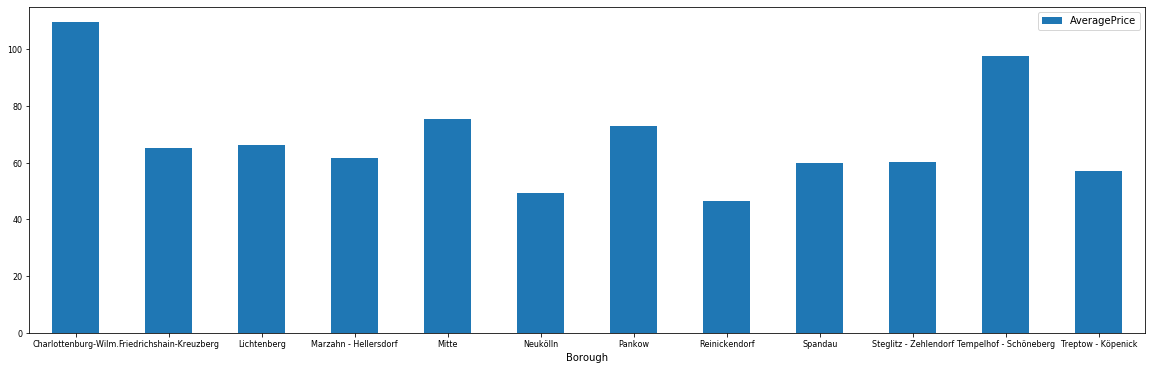

In [12]:
ax = berlin_df.plot.bar(x='Borough', y='AveragePrice', rot=0,figsize=(20, 6), legend=True, fontsize=8)

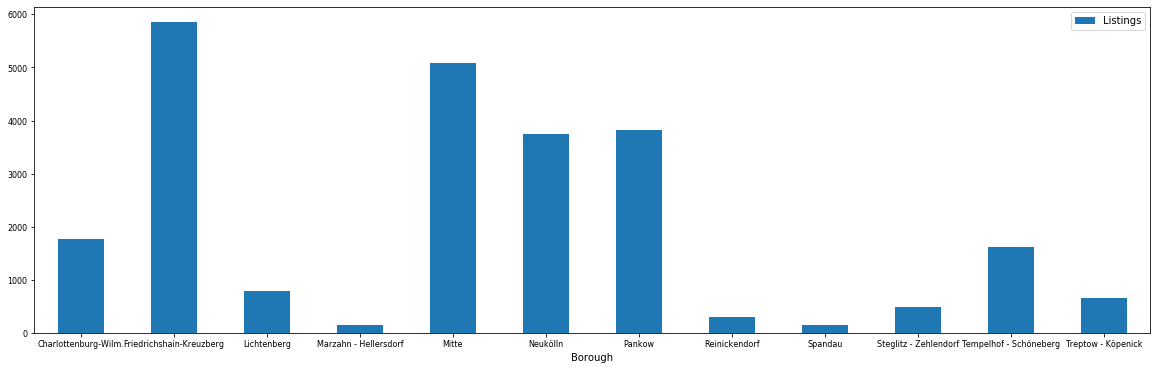

In [13]:
ax = berlin_df.plot.bar(x='Borough', y='Listings', rot=0,figsize=(20, 6), legend=True, fontsize=8)

## Methodology

After retrieving geodata from the mentioned APIs, I will analyse each neighborhoods using various available data sources.

First of all, I'll retrieve available Berlin areas from a dataset available at InsideAirbnb. Then, from the same website, I'll retrieve current listing data for Airbnb rentals to check how many listing are active in each neighborhood, and the average price. This should give a good indication on how attractive the area is, and the average price people can expect for a short rental.

Another important factor will be public transport. From data publicly available at BVG and DB, we will check the average distance from the closest station, and the time it would take to reach the city center. As a city center I've selected the Stadtmitte U-Bahn station.

Finally, we will check each area for venues availability, analysed for each cohort. Young professionals will be more interested in proximity to city center, cafes and restaurants, while families will value proximity to schools, healthcare providers and public parks.

## Analysis

We can now create a Berlin map, using Folium. Let's import the required libraries.

In [9]:
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c conda-forge geopy --yes

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [14]:
import folium
from folium import plugins
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim

We then use geopy to get the coordinates of Berlin.

In [15]:
address = 'Berlin, Germany'

geolocator = Nominatim(user_agent="berlin_search")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("Berlin latitude {} longitude {}".format(latitude, longitude))

Berlin latitude 52.5170365 longitude 13.3888599


Let's add the coordinates of each borough in our Berlin dataframe.

In [17]:
def get_address_lat(address):
    location = geolocator.geocode(address)
    return location.latitude

def get_address_lon(address):
    location = geolocator.geocode(address)
    return location.longitude

def build_address_string(borough):
    boroughName = borough.split("-")[0]
    return boroughName + ", Berlin, Germany"

berlin_df['latitude'] = berlin_df.apply(lambda row: get_address_lat(build_address_string(row['Borough'])), axis=1)
berlin_df['longitude'] = berlin_df.apply(lambda row: get_address_lon(build_address_string(row['Borough'])), axis=1)
    
berlin_df

,Borough,Neighborhood,Listings,AveragePrice,latitude,longitude
0,Charlottenburg-Wilm.,"Barstraße,Charlottenburg Nord,Düsseldorfer Str...",1766,109.46,52.52,13.31
1,Friedrichshain-Kreuzberg,"Frankfurter Allee Nord,Frankfurter Allee Süd F...",5854,65.17,52.51,13.45
2,Lichtenberg,"Alt-Hohenschönhausen Nord,Alt-Hohenschönhausen...",792,66.10,52.53,13.51
3,Marzahn - Hellersdorf,"Biesdorf,Hellersdorf-Nord,Hellersdorf-Ost,Hell...",142,61.42,52.54,13.56
4,Mitte,"Alexanderplatz,Brunnenstr. Nord,Brunnenstr. Sü...",5082,75.46,52.52,13.40
5,Neukölln,"Britz,Buckow,Buckow Nord,Gropiusstadt,Köllnisc...",3753,49.19,52.48,13.44
6,Pankow,"Blankenburg/Heinersdorf/Märchenland,Blankenfel...",3818,72.89,52.60,13.44
7,Reinickendorf,"MV 1,MV 2,Nord 1,Nord 2,Ost 1,Ost 2,West 1,Wes...",304,46.61,52.60,13.30
8,Spandau,"Brunsbütteler Damm,Falkenhagener Feld,Gatow / ...",138,59.83,52.52,13.20
9,Steglitz - Zehlendorf,"Albrechtstr.,Drakestr.,Lankwitz,Ostpreußendamm...",489,60.36,52.46,13.32


### Clustering

Let's now divide Berlin neighborhoods in clusters, to better visualise the current short letting situation. For this, we will use K-means Clustering.

In [18]:
from sklearn.cluster import KMeans

In [19]:
berlin_grouped = berlin_df.drop(columns=['Borough','Neighborhood','latitude','longitude'])
berlin_grouped

,Listings,AveragePrice
0,1766,109.46
1,5854,65.17
2,792,66.10
3,142,61.42
4,5082,75.46
5,3753,49.19
6,3818,72.89
7,304,46.61
8,138,59.83
9,489,60.36


In [20]:
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_grouped)
kmeans.labels_[0:10] 

array([0, 2, 0, 0, 2, 1, 1, 0, 0, 0], dtype=int32)

And add back the clusters label into our original Berlin dataframe.

In [21]:
berlin_df.insert(0, 'Cluster Label', kmeans.labels_)
berlin_df

,Cluster Label,Borough,Neighborhood,Listings,AveragePrice,latitude,longitude
0,0,Charlottenburg-Wilm.,"Barstraße,Charlottenburg Nord,Düsseldorfer Str...",1766,109.46,52.52,13.31
1,2,Friedrichshain-Kreuzberg,"Frankfurter Allee Nord,Frankfurter Allee Süd F...",5854,65.17,52.51,13.45
2,0,Lichtenberg,"Alt-Hohenschönhausen Nord,Alt-Hohenschönhausen...",792,66.10,52.53,13.51
3,0,Marzahn - Hellersdorf,"Biesdorf,Hellersdorf-Nord,Hellersdorf-Ost,Hell...",142,61.42,52.54,13.56
4,2,Mitte,"Alexanderplatz,Brunnenstr. Nord,Brunnenstr. Sü...",5082,75.46,52.52,13.40
5,1,Neukölln,"Britz,Buckow,Buckow Nord,Gropiusstadt,Köllnisc...",3753,49.19,52.48,13.44
6,1,Pankow,"Blankenburg/Heinersdorf/Märchenland,Blankenfel...",3818,72.89,52.60,13.44
7,0,Reinickendorf,"MV 1,MV 2,Nord 1,Nord 2,Ost 1,Ost 2,West 1,Wes...",304,46.61,52.60,13.30
8,0,Spandau,"Brunsbütteler Damm,Falkenhagener Feld,Gatow / ...",138,59.83,52.52,13.20
9,0,Steglitz - Zehlendorf,"Albrechtstr.,Drakestr.,Lankwitz,Ostpreußendamm...",489,60.36,52.46,13.32


Finally, let's create a Folium map showing the different clusters.

In [22]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [23]:
map_berlin_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, neigh, bor, cluster in zip(berlin_df['latitude'], berlin_df['longitude'], berlin_df['Neighborhood'], berlin_df['Borough'], berlin_df['Cluster Label']):
    label = folium.Popup(str(bor) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_berlin_clusters)
       
map_berlin_clusters

### Facilities and venues

Let's now use the Foursquare API to analyse each borough based on venues and facilities, and see if there is a correlation between higher prices and availability.

In [24]:
CLIENT_ID = 'U0WJDXRHR2M2LOHM43JPDV12GK0PA4B1V0LFNFL42UQ2N1NH'
CLIENT_SECRET = 'DHIBQK11ZZSNTACZGKPXKTC5ELHTVEZDXA3WDXBQTS2ZG2ER'
VERSION = '20190814'
LIMIT = 50

In [25]:
import requests

ignoredCategories = ['River', 'Windmill']

groupedCategories = {}
groupedCategories['Restaurant'] = ['Restaurant', 'Burger Joint','Trattoria', 'Bistro', 'Noodle House','Steakhouse','Pizza','Taverna']
groupedCategories['Café/Bar'] = ['Donut','Café', 'Bagel Shop','Breakfast Spot', 'Ice Cream Shop', 'Cafeteria', 'Coffee Shop', 'Pub', 'Bar', 'Nightclub', 'Beer Garden', 'Tea Room', 'Jazz Club','Lounge','Gaming Cafe','Gastropub']
groupedCategories['Grocery'] = ['Supermarket','Grocery', 'Bakery', 'Market','Pie Shop','Pastry Shop', 'Gourmet Shop', 'Food & Drink Shop', 'Farmers Market','Beer Store','Wine Shop','Organic Grocery']
groupedCategories['Arts/Culture/Entertainment'] = ['Theater','Museum','Art Gallery','Concert Hall','Music Venue','Opera House','Performing Arts Venue','Multiplex','Comedy Club','Monument','Church','Historic','Memorial']
groupedCategories['Transport'] = ['Station','Harbor','Bus Stop','Bike Rental','Rental Car']
groupedCategories['Imbiss'] = ['Sandwich','Hot Dog','Currywurst','Fried Chicken']
groupedCategories['Nature'] = ['Nature','River', 'Lake','Garden','Park','Forest','Beach','Scenic','Mountain']
groupedCategories['Other Stores'] = ['Sporting Goods','Pet Store','Drugstore', 'Toy','Outdoor','Furniture','Bookstore','Clothing','Record','Flower','Mobile Phone','Hardware', 'Big Box','Electronics','Baby Store','Cosmetics','Convenience','Candy Store','Adult']
groupedCategories['Fitness'] = ['Gym', 'Yoga','Sauna','Climbing','Pool','Spa','Athletics']
groupedCategories['Hospitality'] = ['Hotel', 'Hostel']


def getNearbyVenues(name, lat, lng, radius=2000):
    
    venues_list=[]

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)
    
    json = requests.get(url).json()
    
    exceeded = False
    if 'errorType' in json['meta']:
        exceeded = (json['meta']['errorType'] == 'quota_exceeded')
        
    if(exceeded == True):
        print("Quota exceeded! No results returned for " + name)
        return None;
    else:
        results = json["response"]['groups'][0]['items']

        for v in results:
            category = v['venue']['categories'][0]['name']
            for g in groupedCategories.keys():
                values = groupedCategories[g]
                for val in values:
                    if(val in category):
                        v['venue']['categories'][0]['name'] = g  


        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighbourhood', 
                      'NeighborhoodLatitude', 
                      'NeighborhoodLongitude', 
                      'Venue', 
                      'VenueLatitude', 
                      'VenueLongitude', 
                      'VenueCategory']

        for i in ignoredCategories:
            nearby_venues = nearby_venues[nearby_venues.VenueCategory != i]

        return(nearby_venues)

I'll then retrieve venues for each borough in Berlin, and then analyse what type of venues are more common in each area.

Let's now get a list of frequencies for the most common venues of each borough. I'll also clean up the data a bit, group the venues and compute their count, and sort by descending count.

In [26]:
venuesDict = {}

for index,row in berlin_df.iterrows():
    venues = getNearbyVenues(row['Borough'], row['latitude'], row['longitude'])
    venues.drop(columns=['Venue','Neighbourhood','NeighborhoodLongitude','NeighborhoodLatitude','VenueLatitude','VenueLongitude'], inplace=True)
    venues['count'] = venues.groupby('VenueCategory')['VenueCategory'].transform('count')
    venues = venues.drop_duplicates().reset_index().drop(columns=['index'])
    venues.sort_values(by=['count'], inplace=True, ascending=False)
    venuesDict[index] = venues

With the data now available, it's time to analyse each borough in details.

#### Charlottenburg-Wilm.

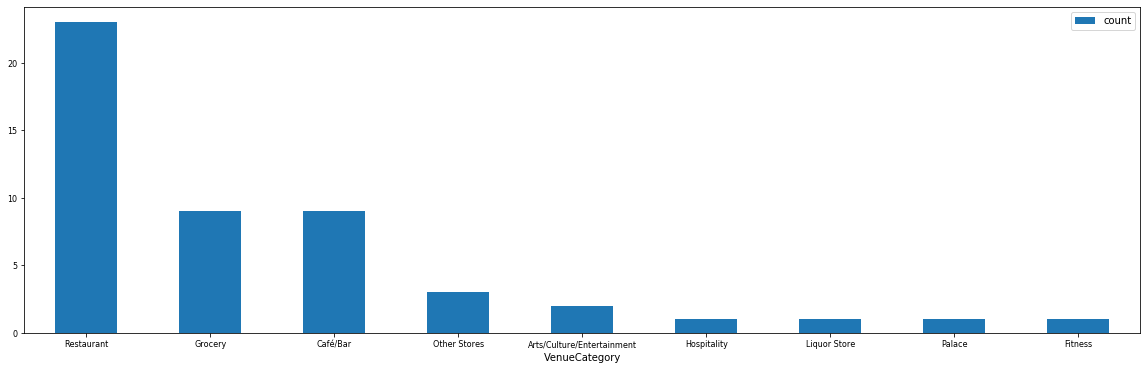

In [27]:
ax = venuesDict[0].plot.bar(x='VenueCategory', y='count', rot=0,figsize=(20, 6), legend=True, fontsize=8)

#### Friedrichshain-Kreuzberg

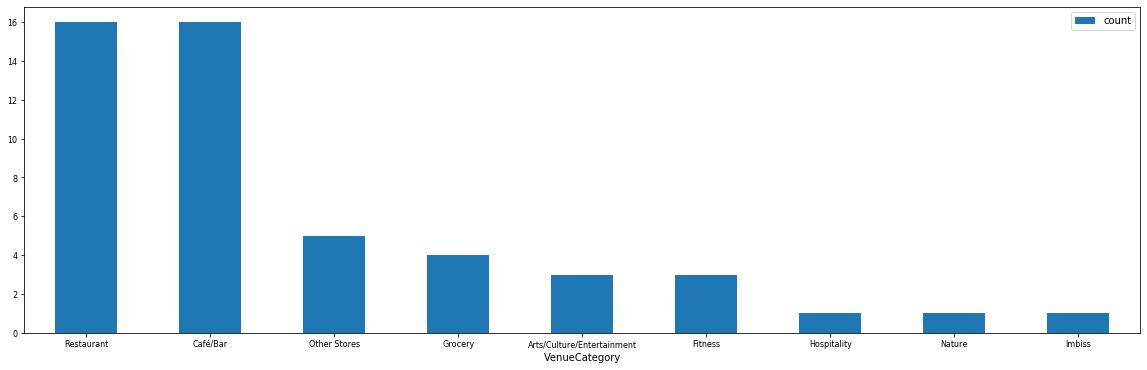

In [28]:
ax = venuesDict[1].plot.bar(x='VenueCategory', y='count', rot=0,figsize=(20, 6), legend=True, fontsize=8)

#### Lichtenberg

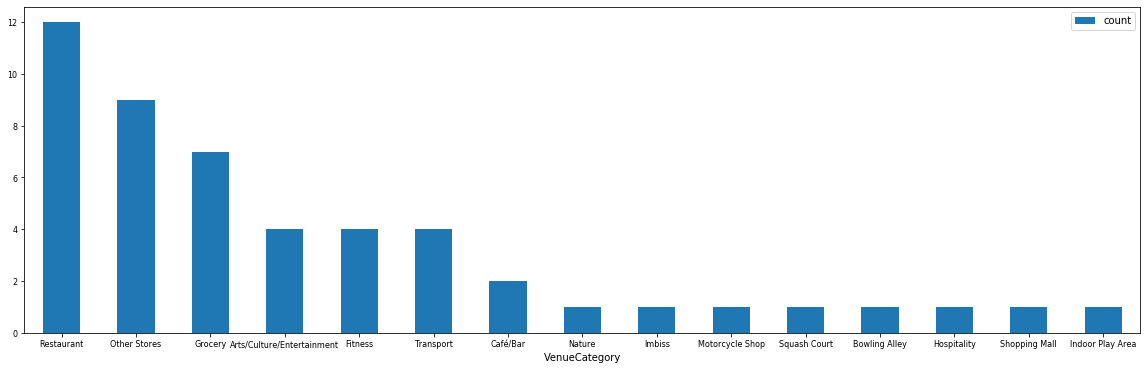

In [29]:
ax = venuesDict[2].plot.bar(x='VenueCategory', y='count', rot=0,figsize=(20, 6), legend=True, fontsize=8)

#### Marzahn - Hellersdorf

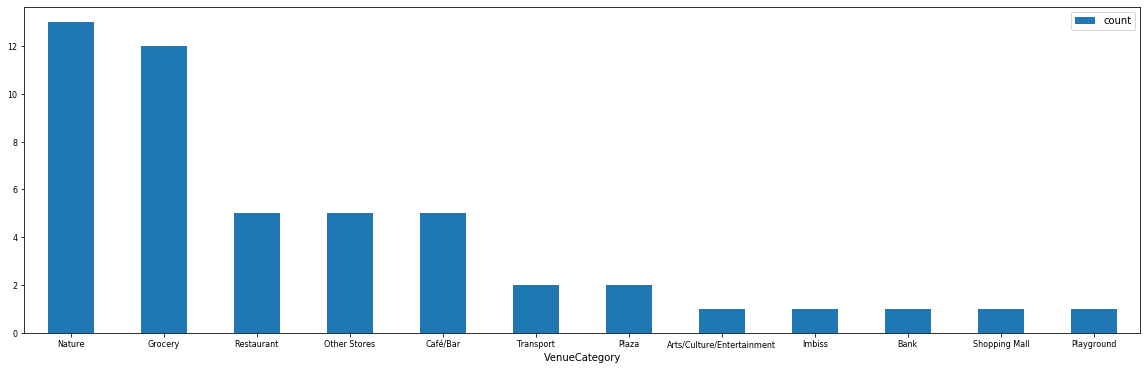

In [30]:
ax = venuesDict[3].plot.bar(x='VenueCategory', y='count', rot=0,figsize=(20, 6), legend=True, fontsize=8)

#### Mitte

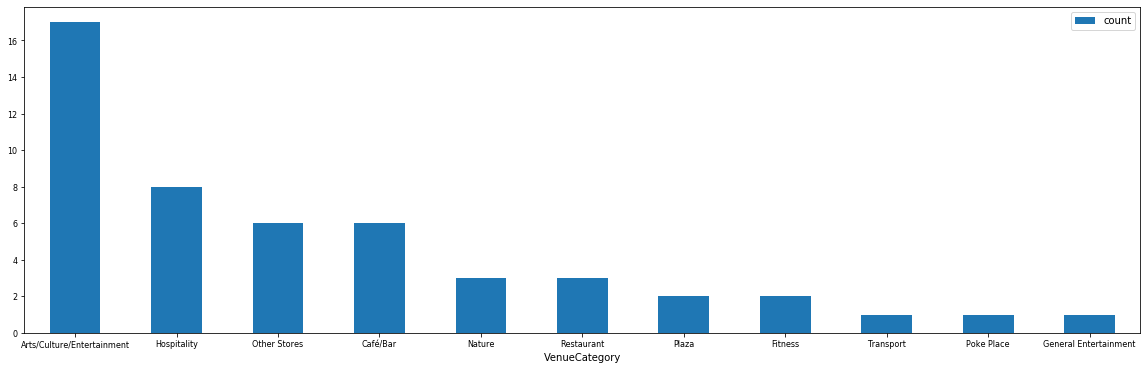

In [32]:
venuesDict[4].plot.bar(x='VenueCategory', y='count', rot=0,figsize=(20, 6), legend=True, fontsize=8)

#### Neukölln

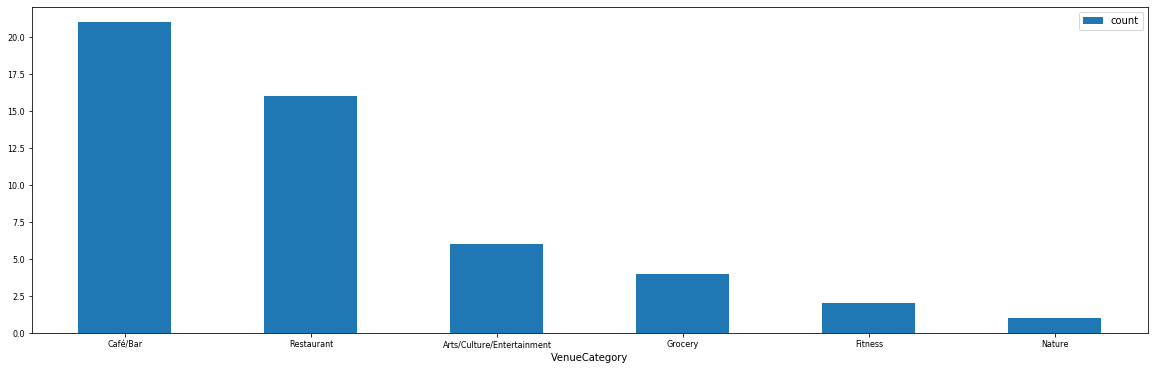

In [34]:
venuesDict[5].plot.bar(x='VenueCategory', y='count', rot=0,figsize=(20, 6), legend=True, fontsize=8)

#### Pankow

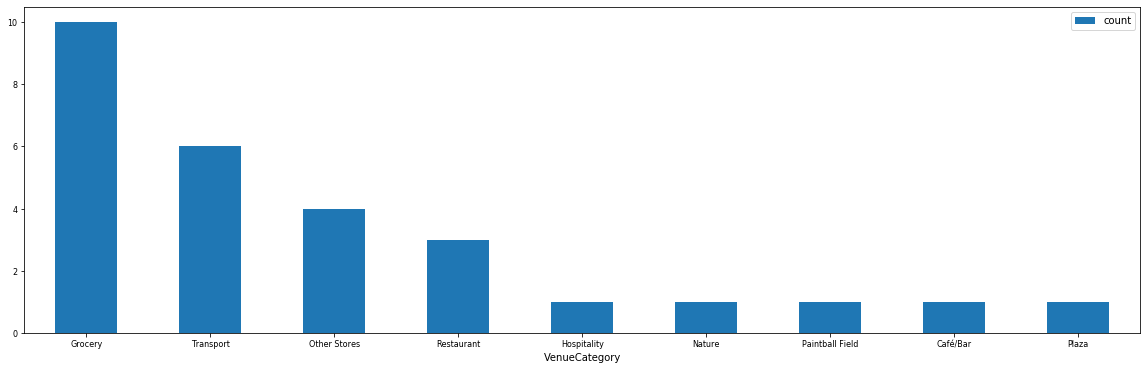

In [35]:
venuesDict[6].plot.bar(x='VenueCategory', y='count', rot=0,figsize=(20, 6), legend=True, fontsize=8)

#### Reinickendorf

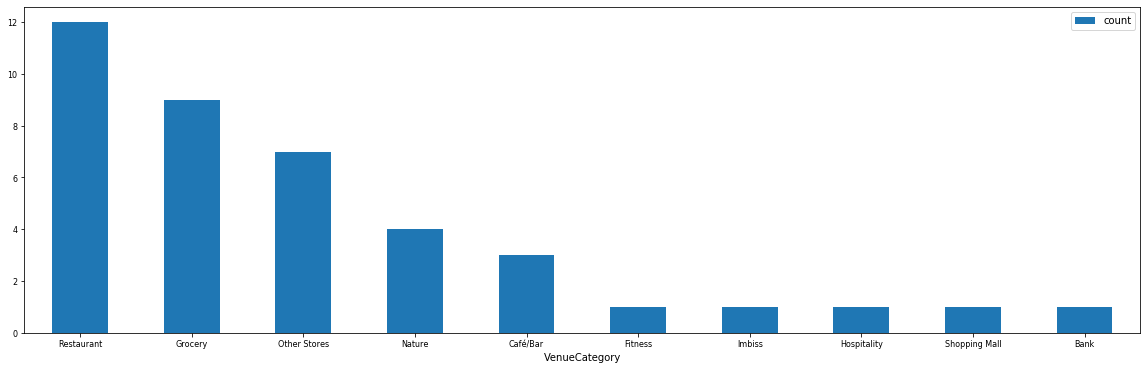

In [36]:
venuesDict[7].plot.bar(x='VenueCategory', y='count', rot=0,figsize=(20, 6), legend=True, fontsize=8)

#### Spandau

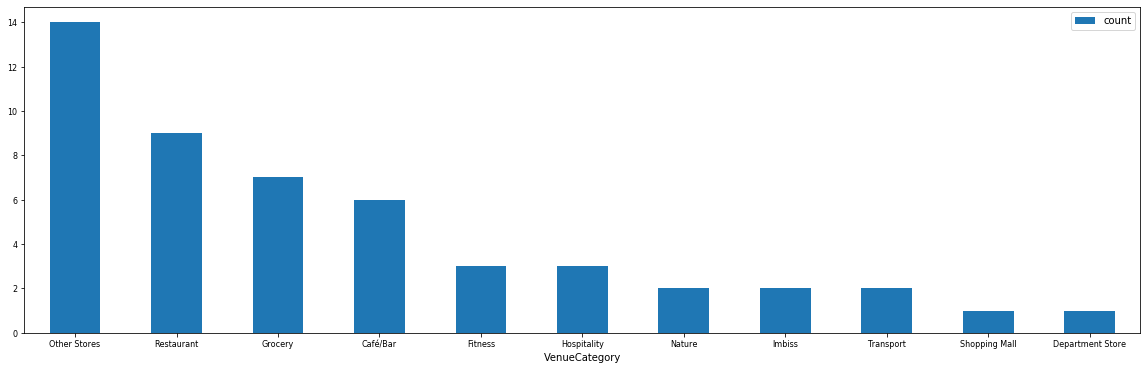

In [37]:
venuesDict[8].plot.bar(x='VenueCategory', y='count', rot=0,figsize=(20, 6), legend=True, fontsize=8)

#### Steglitz - Zehlendorf

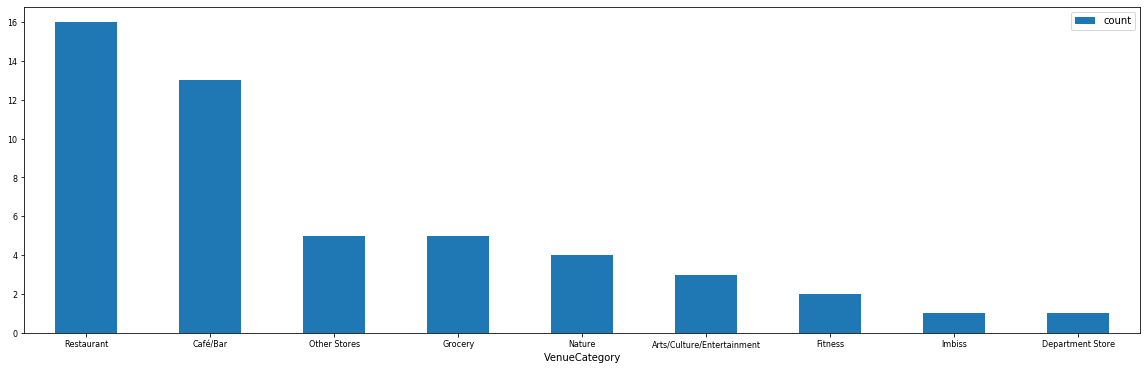

In [38]:
venuesDict[9].plot.bar(x='VenueCategory', y='count', rot=0,figsize=(20, 6), legend=True, fontsize=8)

#### Tempelhof - Schöneberg

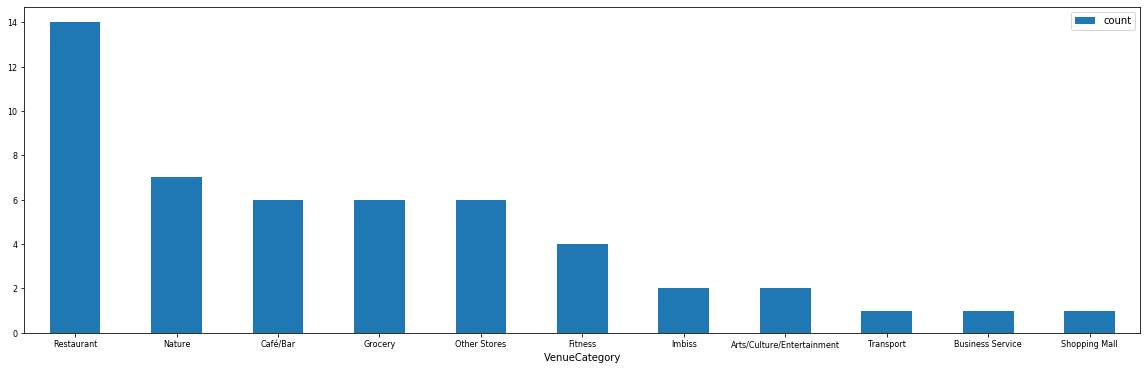

In [39]:
venuesDict[10].plot.bar(x='VenueCategory', y='count', rot=0,figsize=(20, 6), legend=True, fontsize=8)

#### Treptow - Köpenick

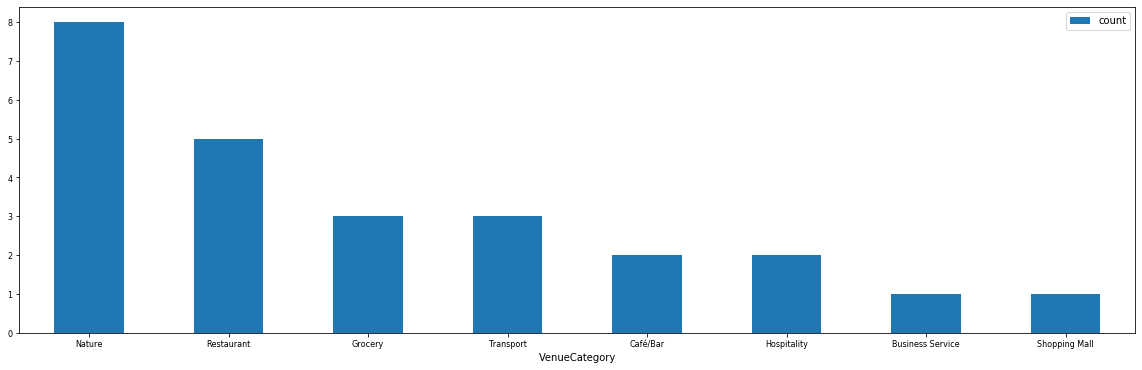

In [40]:
venuesDict[11].plot.bar(x='VenueCategory', y='count', rot=0,figsize=(20, 6), legend=True, fontsize=8)

## Results and Discussion

After having analysed all boroughs in Berlin, we are now able to look at a clear picture of the short-letting prices, in relation to the venues and proximity to the city centre.

Being directly in the centre, Mitte has the highest amount of short-lets, along with a prevalence of hotels, museums and restaurants. For this reason, it's not the best option for rentals.

Boroughs such as Lichtenberg, Tempelhof - Schöneberg, Spandau, and Reinickendorf have a higher prevalence of Supermarkets, Restaurants, and other facilities that are more relevant for a residential area. In the same way, there are a low number of short-lettings in these areas. 

This is also shown by the Clustering results I have shown above. The boroughs just mentioned are all in Cluster 0, while Mitte is together with Friedrichshain-Kreuzberg in Cluster 2, being touristic areas with higher availability of short-lets.

## Conclusion

Using the data available in this report, you will be able to have a better idea of the different areas of Berlin, in relation to the facilities and venues available. A stakeholder will then be able to pick an area depending on the personal interest and business, such as a residential, quiet area for a young family, or a more up-and-coming area for young professional with many cafes and bars.